In [1]:
import os 
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from datetime import datetime
import itertools
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import QuantileTransformer
from scipy.signal import detrend
from statsmodels.stats.weightstats import DescrStatsW
from arch import arch_model
import numpy as np
from scipy import signal, fft
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300
OBS_THRESH = 120
START_DT = datetime(1984, 12, 31)
END_DT = datetime(2024, 12, 31)
MCAP_THRESH = .99
PRC_THRESH = 1

signals = ['b2m', 'c2p', 's2p', 'e2p', 'mom_12_1', 'mom_6_1', 'resid_mom']#, 'strev']
signal_grouping = {
    "Value": ['b2m', 'c2p', 's2p', 'e2p'],
    "Momentum/Reversion": ['mom_12_1', 'mom_6_1', 'resid_mom', 'strev'],
}

In [2]:
def market_coverage(market_cap, thresh):
    """Selects stocks based on market cap threshold."""
    tot_mcap = market_cap.sum()
    target_mcap = tot_mcap * thresh
    pick = market_cap.sort_values(ascending=False).cumsum().loc[lambda x: x <= target_mcap].index
    size_flag = pd.Series(False, index=market_cap.index, dtype=bool)
    size_flag[pick] = True
    return size_flag


def cleanup_ts(original_ts, thresh):
    segment_mapping = (original_ts.notna() != original_ts.notna().shift(1)).cumsum()
    segment_mapping_notna = segment_mapping[original_ts.notna()]
    continuous_segment_id = segment_mapping_notna[original_ts.notna()].groupby(segment_mapping_notna[original_ts.notna()]).count().idxmax()
    continuous_ts = original_ts[segment_mapping == continuous_segment_id].reindex(original_ts.index)
    if continuous_ts.count() >= thresh:
        return continuous_ts
    else:
        return pd.Series(index=original_ts.index)

In [3]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")
mcap = crsp['shrout'].mul(crsp['prc'].abs()).astype(float)

In [4]:
# Filters
# signal_count = raw_signals.apply(lambda x: x.groupby(level="permno").cumcount())
# nobs_flag = signal_count >= OBS_THRESH
micro_flag = mcap.groupby("date", group_keys=False).apply(market_coverage, .99)  # Remove micr-cap stocks

In [5]:
# Cross-sectional standardization
collect_signals = {}

for sgnl in tqdm(signals):
    collect_std = {}
    X = raw_signals.loc[micro_flag.reindex(raw_signals.index).fillna(False), sgnl].unstack().loc[START_DT:END_DT]
    for dt in X.index:
        x_t = X.loc[dt].dropna()
        qt = QuantileTransformer(output_distribution='normal')
        qt.fit(x_t.to_frame())
        z_t = pd.Series(qt.transform(x_t.to_frame()).flatten(), index=x_t.index)
        collect_std[dt] = z_t

    collect_signals[sgnl] = pd.DataFrame.from_dict(collect_std, orient='index').sort_index().stack()
    
Z = pd.DataFrame.from_dict(collect_signals)
Z.index.names = ["date", "permno"]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# Clean-up the time series so it considers signals with enough datapoints and not lagoons in between signals
clean_ts = {sgnl: Z[sgnl].dropna().unstack().apply(cleanup_ts, args=(OBS_THRESH, )).dropna(how='all', axis=1).stack() for sgnl in Z.columns}
Z = pd.DataFrame.from_dict(clean_ts)

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


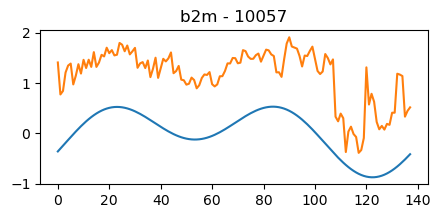

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


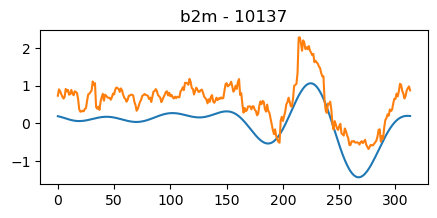

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


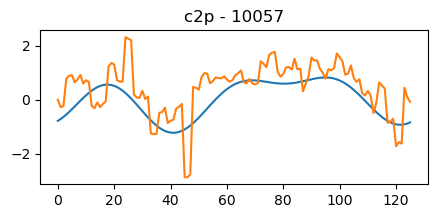

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


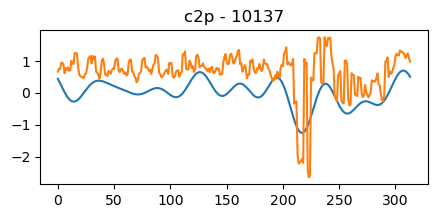

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


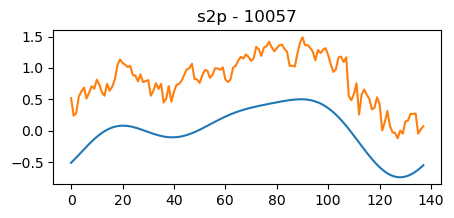

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


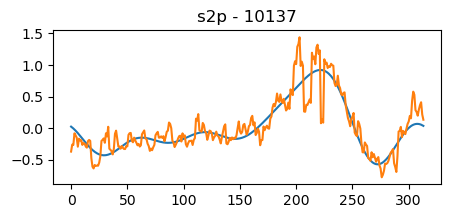

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


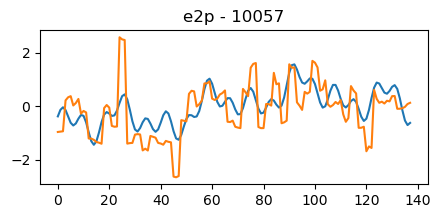

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


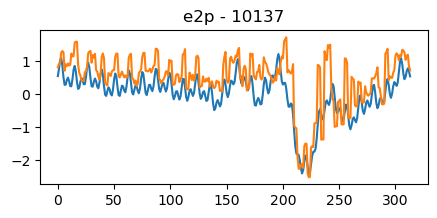

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


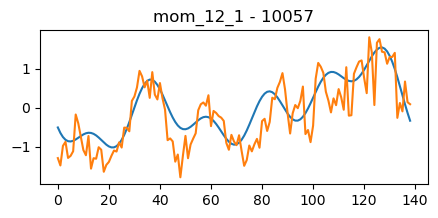

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


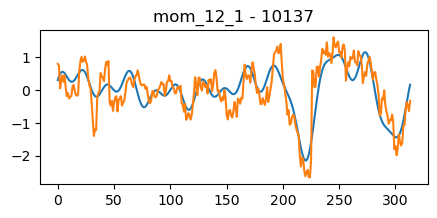

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


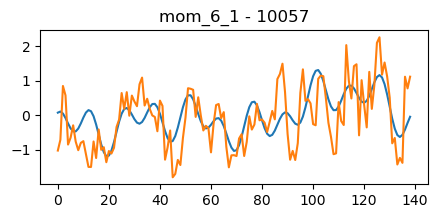

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


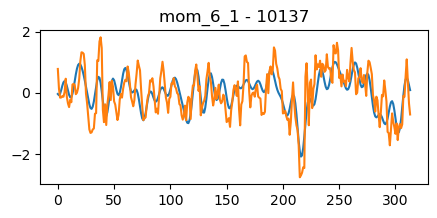

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


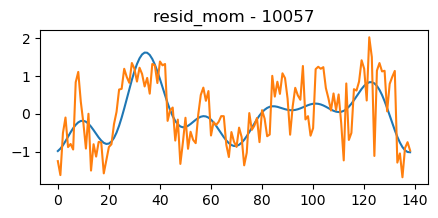

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


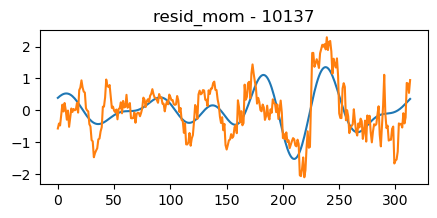

In [ ]:
sec_ids = Z.index.get_level_values("permno").unique()[:2]
for sgnl in signals:
    for sec_id in sec_ids:
        x_t = Z[sgnl].xs(sec_id, level=1).dropna()
        if len(z_t) > 0:
            n = len(z_t)
            fhat = fft.rfft(z_t.values, n)
            f, Pxx_den = signal.periodogram(z_t, 10e3, scaling='density')

            # Clustering the frequency domain representation
            cat = MiniBatchKMeans(n_clusters=3, n_init="auto", init="k-means++", random_state=12345).fit(Pxx_den.reshape(-1, 1))
            filt_val = cat.cluster_centers_.flatten().argmax()
            filt_flags = cat.labels_ == filt_val
            filt_fhat = np.where(filt_flags, fhat, 0)
            s_t = fft.irfft(filt_fhat, n=n)

            pd.Series(s_t).plot(figsize=(5, 2), title=f"{sgnl} - {int(sec_id)}")
            pd.Series(z_t.values).plot()
            plt.show()

## I should create a table with the wave length of each signal

In [198]:
z_t

Series([], Name: b2m, dtype: float64)

In [196]:
Z[sgnl].xs(sec_id, level=1)

date
1984-12-31    1.409599
1985-01-31    0.774803
1985-02-28    0.844355
1985-03-31    1.210016
1985-04-30    1.348257
                ...   
1996-02-29    1.140055
1996-03-31    0.334230
1996-04-30    0.449143
1996-05-31    0.518735
1996-06-30         NaN
Name: b2m, Length: 139, dtype: float64

In [ ]:
for sec_ids, sgnl in itertools.product(Z., signals):
    pass

NameError: name 'sample_ids' is not defined

In [ ]:
z = Z.xs()

In [143]:
# Sample stocks
length_flags = (raw_signals.groupby("permno").count() > OBS_THRESH).all(axis=1)  # Filter 3: enough observations
sample_flags = pd.concat([length_flags], axis=1).all(axis=1)  # Put together the flags
sample_ids = sample_flags[sample_flags].index
print(len(sample_ids))

2014


In [138]:
for sec_ids, sgnl in itertools.product(sample_ids, signals):
    pass

In [140]:
mcap

permno
10026        3021622.14
10028         186651.28
10032        4239356.16
10044          18463.14
10066           57741.6
              ...      
93397         441087.18
93426         286709.52
93429    20455643.35314
93434          18249.16
93436      1296350630.4
Length: 3806, dtype: Float64

In [139]:
raw_signals

b2m       c2p       s2p       e2p  mom_12_1  \
           permno                                                      
1963-07-31 10006.0       NaN       NaN       NaN       NaN       NaN   
           10014.0       NaN       NaN       NaN       NaN       NaN   
           10030.0       NaN       NaN       NaN       NaN       NaN   
           10057.0       NaN       NaN       NaN       NaN       NaN   
           10102.0       NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
2024-12-31 93397.0  0.435179  0.000043  0.099438 -0.004215  0.261936   
           93426.0  1.122973  0.016749  0.253403  0.002679 -0.443939   
           93429.0  0.209214  0.011175  0.054146  0.009606  0.154830   
           93434.0  1.915211 -0.304507  0.278205 -0.342701 -0.689228   
           93436.0  0.056245  0.002796  0.019830  0.001642  0.281452   

                     mom_6_1 resid_mom     strev  
           permno                                 
1963-07-31 10006.0       NaN       NaN  0.049044  
           10014.0       NaN       NaN  0.002704  
           10030.0       NaN       NaN  0.068639  
           10057.0       NaN       NaN  0.101756  
           10102.0       NaN       NaN  0.019161  
...                      ...       ...       ...  
2024-12-31 93397.0  0.275933  0.115129  0.129136  
           93426.0 -0.304235 -0.354125 -0.017907  
           93429.0  0.224226 -0.009494  0.103631  
           93434.0  0.005902 -0.228591 -0.121893  
           93436.0  0.537015 -0.017601 -0.153843  

[3384361 rows x 8 columns]

In [55]:
x_t = raw_signals.xs(sec_ids, level='permno')[sgnl].dropna()

# ------------------------------------
# LNA
z_t = detrend(x_t)  # Remove linear trend

mdl = arch_model(z_t, p=1, o=0, q=1, lags=1, mean="AR", rescale=False)
res = mdl.fit(disp="off")
z_t = np.divide(z_t, res.conditional_volatility)  # GARCH standardization
z_t = z_t[~np.isnan(z_t)]

scaler = StandardScaler().fit(z_t.reshape(-1, 1))
z_t = scaler.transform(z_t.reshape(-1, 1)).flatten()  # Regular standardization

In [69]:
n = len(z_t)
fhat = fft.rfft(z_t, n)
f, Pxx_den = signal.periodogram(z_t, 10e3, scaling='density')

# Clustering the frequency domain representation
cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=12345).fit(Pxx_den.reshape(-1, 1))
filt_val = cat.cluster_centers_.flatten().argmax()
filt_flags = cat.labels_ == filt_val
filt_fhat = np.where(filt_flags, fhat, 0)
s_t = fft.irfft(filt_fhat, n=n)

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


<Axes: >

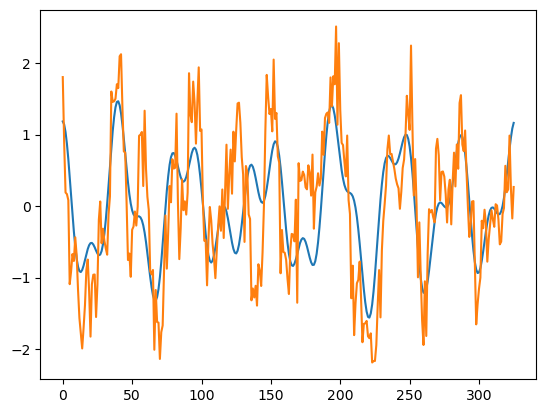

In [ ]:
pd.Series(s_t).plot()
pd.Series(z_t).plot()

<Axes: >

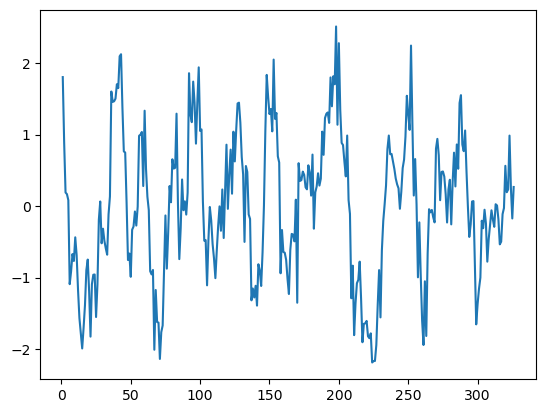

In [42]:
pd.Series(z_t).plot()

<Axes: >

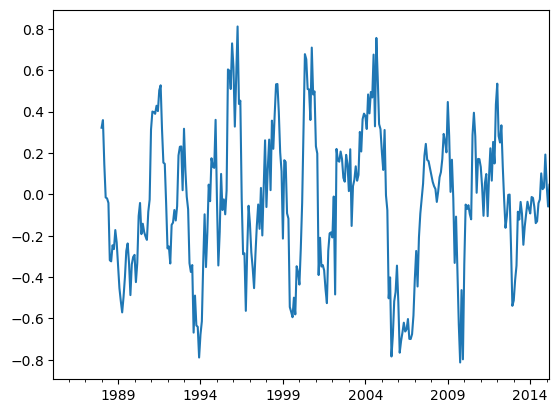

In [ ]:
x_t.plot()

n = len(x)
fhat = fft.rfft(x.values, n)
f, Pxx_den = signal.periodogram(x, 10e3, scaling='density')

# Clustering the frequency domain representation
# cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=1234).fit(Pxx_den.reshape(-1, 1))
# filt_val = cat.cluster_centers_.flatten().argmax()
# filt_flags = cat.labels_ == filt_val

In [3]:
S = raw_signals["mom_12_1"].unstack()
last_valid_obs = S.iloc[-1].notnull()
enough_obs = S.count() > OBS_THRESH
is_valid = enough_obs & last_valid_obs  # Time series to be used to estimate the parameters
S = S.loc[:, is_valid]  # Filtered subset

In [4]:
len(is_valid)

26141

<Axes: >

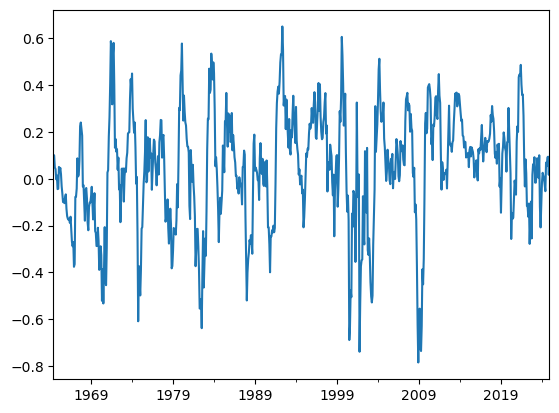

In [4]:
_id = 10145
s = S[_id].dropna()
s.plot()

In [5]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(s.to_frame())

In [6]:
# LNA
s_a = transformer.transform(s.values.reshape(-1, 1)).flatten()

<Axes: >

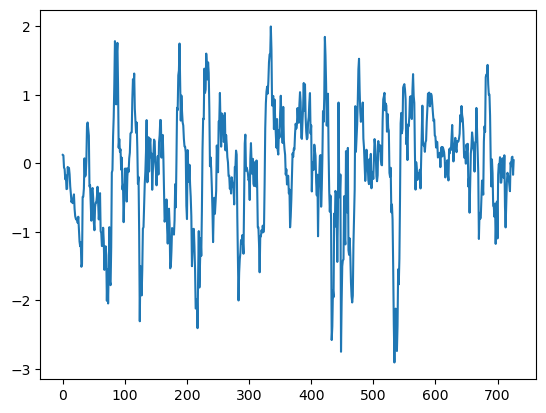

In [7]:
pd.Series(s_a).plot()